In [1]:
!apt install libspatialindex-dev
!pip install geopandas
!pip install rtree
!pip install osmnx

'apt' is not recognized as an internal or external command,
operable program or batch file.


  Attempting uninstall: Shapely
    Found existing installation: Shapely 1.6.4.post1
    Uninstalling Shapely-1.6.4.post1:
      Successfully uninstalled Shapely-1.6.4.post1
  Attempting uninstall: pyproj
    Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.6.3
    Uninstalling geopandas-0.6.3:
      Successfully uninstalled geopandas-0.6.3


In [5]:
import osmnx as ox

#chula = ox.graph_from_address('Chulalongkorn University, Bangkok, Thailand', dist=1000)
cnx = ox.graph_from_address('Chiang Mai, Thailand', dist=1000)

C:\Users\VoVo9001\Anaconda3\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\VoVo9001\Anaconda3\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\VoVo9001\Anaconda3\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


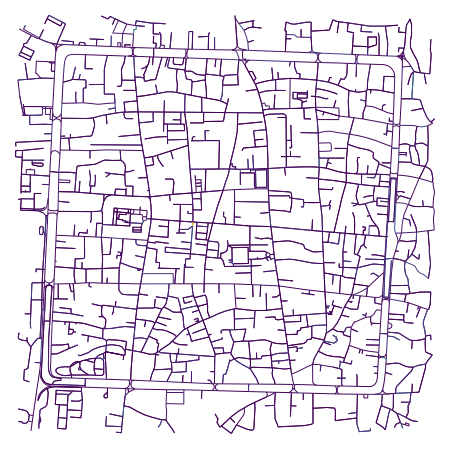

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ox.plot_graph(cnx, bgcolor='#fff', node_size=0, edge_color=ox.plot.get_edge_colors_by_attr(chula, attr='length'))

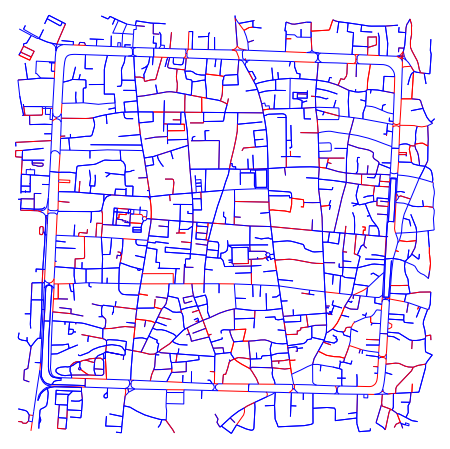

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
ox.plot_graph(cnx, bgcolor='#fff', node_size=0, edge_color=['r' if data['oneway'] else 'b' for u, v, key, data in chula.edges(keys=True, data=True)])

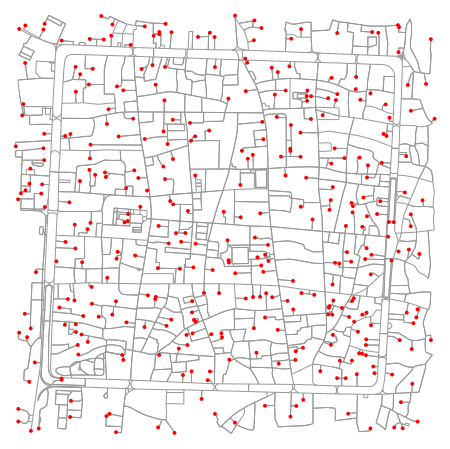

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
culdesacs = [key for key, value in ox.utils_graph.count_streets_per_node(cnx).items() if value==1]
nc = ['r' if node in culdesacs else 'none' for node in cnx.nodes()]
ox.plot_graph(cnx, bgcolor='#fff', node_color=nc)

In [10]:
# chula_proj = ox.project_graph(chula)
extended_stats = ox.extended_stats(cnx, ecc=True, bc=True, cc=True)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(208217259, 0.1937361299476375)

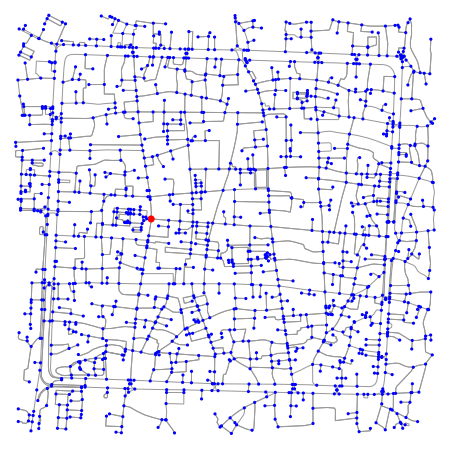

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
nc = ['r' if node==max_node else 'b' for node in cnx.nodes()]
ns = [50 if node==max_node else 10 for node in cnx.nodes()]
ox.plot_graph(cnx, bgcolor='#fff', node_size=ns, node_color=nc, node_zorder=2)

In [12]:
cnx_nodes = ox.graph_to_gdfs(cnx, edges=False)
x, y = cnx_nodes['geometry'].unary_union.centroid.xy
cnx_center = ox.get_nearest_node(cnx, (y[0], x[0]))
for u, v, k, data in cnx.edges(data=True, keys=True):
  data['time'] = data['length'] / 75

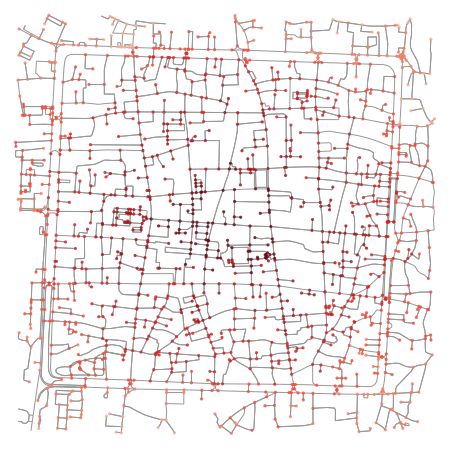

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [15]:
import networkx as nx
trip_times = [30, 25, 20, 15, 10, 5]
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
node_colors = {}
for trip_time, color in zip(trip_times, iso_colors):
  subgraph = nx.ego_graph(cnx, cnx_center, radius=trip_time, distance='time')
  for node in subgraph.nodes():
    node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in cnx.nodes()]
ns = [10 if node in node_colors else 0 for node in cnx.nodes()]
ox.plot_graph(cnx, bgcolor='#fff', node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

C:\Users\VoVo9001\Anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


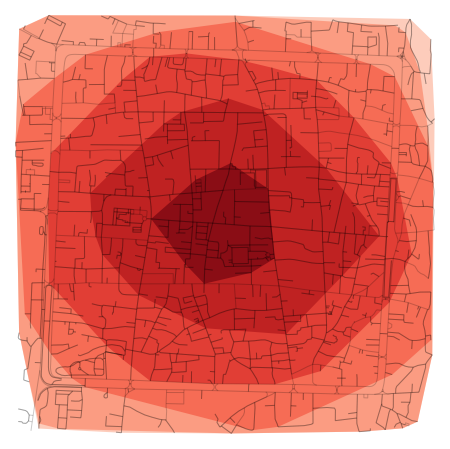

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from descartes import PolygonPatch

isochrone_polys = []
for trip_time in trip_times:
  subgraph = nx.ego_graph(cnx, cnx_center, radius=trip_time, distance='time')
  node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
  isochrone_polys.append(bounding_poly)
fig, ax = ox.plot_graph(cnx, bgcolor='#fff', show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
  patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
  ax.add_patch(patch)
plt.show()

In [ ]:
import osmnx as ox

def bottleneck(lat, long, filename):
  area = ox.graph_from_point((lat, long), dist=1000)
  stats = ox.extended_stats(area, ecc=True, bc=True, cc=True)
  max_node, max_bc = max(stats['betweenness_centrality'].items(), key=lambda x: x[1])
  nc = ['r' if stats['betweenness_centrality'][node] > stats['betweenness_centrality_avg'] else '#000000' for node in area.nodes()]
  ns = [stats['betweenness_centrality'][node]*2000 for node in area.nodes()]
  ox.plot_graph(area, bgcolor='#fff', node_size=ns, node_color=nc, node_zorder=2, figsize=(10,10), dpi=60, save=True, filepath=filename)

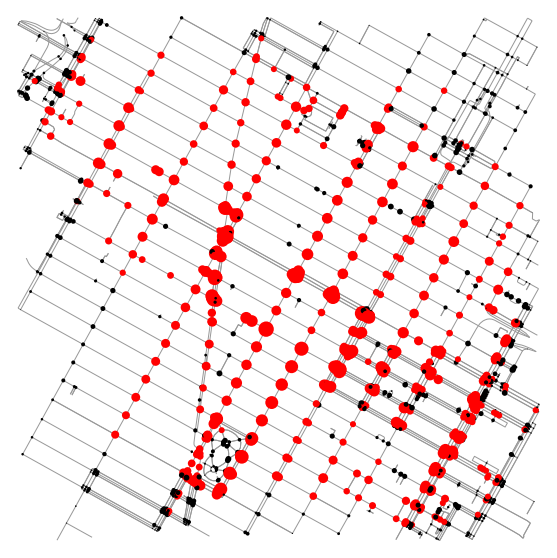

In [ ]:
bottleneck(40.748259, -73.985385, 'nycempire.png')

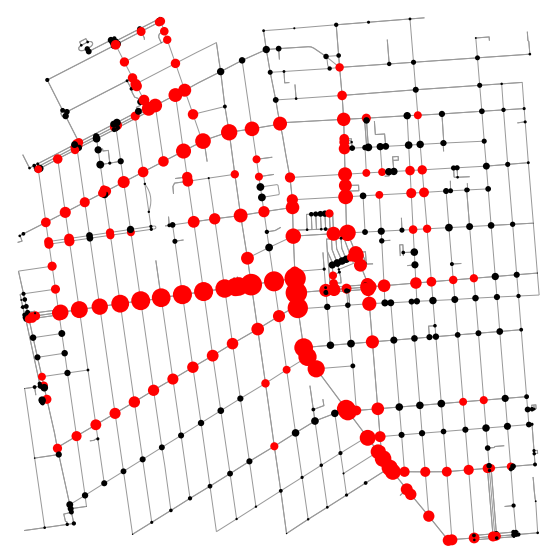

In [ ]:
bottleneck(40.645037, -73.958812, 'nycbrooklyn.png')

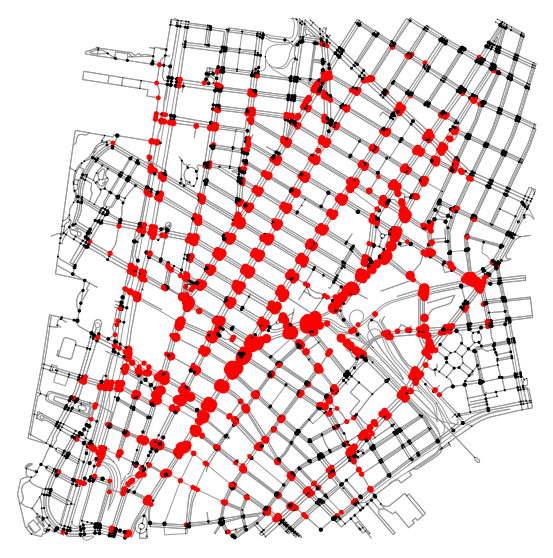

In [ ]:
bottleneck(40.713558, -74.007511, 'nyccityhall.png')

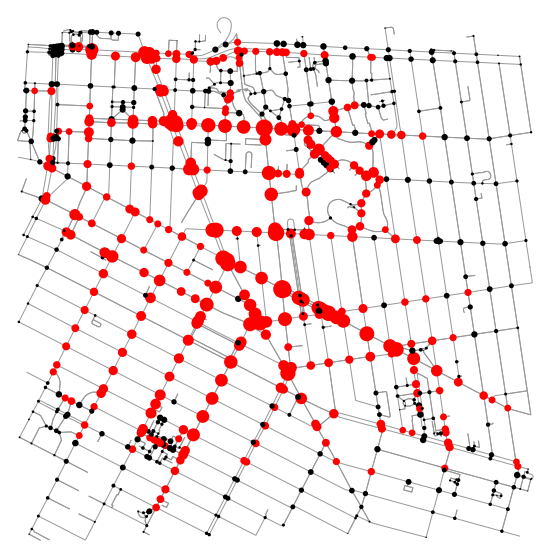

In [ ]:
bottleneck(40.688085, -73.978660, 'nycbam.png')

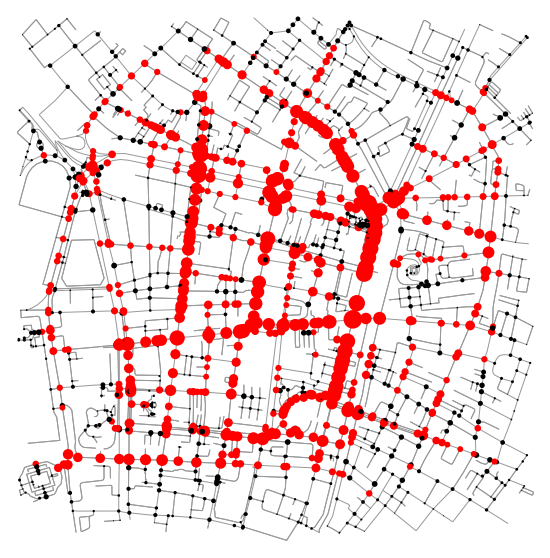

In [ ]:
bottleneck(13.753678, 100.501743, 'bkkcityhall.png')

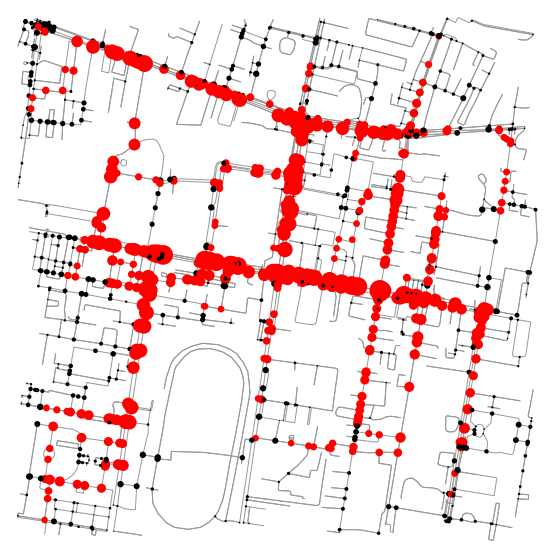

In [ ]:
bottleneck(13.744476, 100.540206, 'bkkctw.png')

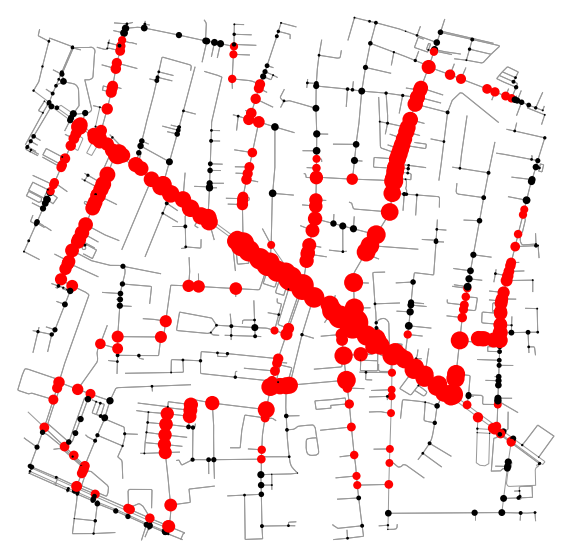

In [ ]:
bottleneck(13.725148, 100.576947, 'bkkthonglor.png')